<a href="https://colab.research.google.com/github/jcumbicosr/processamento-linguagem-natural/blob/main/Busca_Multimodal_por_Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enunciado Exercício 6_7 Busca Multimodal por Embedding

Neste exercício, vamos nos utilizar de modelos de processamento de imagem e texto pré-treinados como geradores de embedding. A tarefa é alinhar esses embeddings, de forma que conceitos textuais produzam embeddings similares a imagens correspondentes. Por exemplo, o embedding produzido pela palavra "car" deve ser similar ao embedding de uma imagem de um carro.

A partir deste treinamento, conseguimos implementar uma busca de imagens por query textual!

## Objetivos Específicos
1) Dados: Implemente o DataLoader do dataset fornecido e comente sobre o batch.

2) Arquitetura: Projetar Embeddings de modelos pré-treinados *congelados* para um espaço comum com projeções lineares.

3) Treino: Inicialmente, treinar alinhamento de Embeddings com Mean Square Error (MSE), que alinha somente pares positivos, computando e reportando também o Cosine Similarity.

4) Busca: Implementar query de busca, retornando a imagem correspondente a uma string a partir do Cosine Similarity como media de similaridade.

5) Melhorar Treinamento: Implementar e treinar com Contrastive Loss, seguindo implementação do paper CLIP leitura dessa semana. A Contrastive Loss deve minimizar a similaridade entre pares de embeddings negativos e maximizar a similaridade entre pares positivos. **Cuidado com composição do batch para Contrastive Loss! Um par de cada classe no máximo**.

6) Busca: Verificar se resultados qualitativos de busca são melhorados com treino com Contrastive Loss.

### Objetivos *Opcionais*
1) Quem tiver recursos computacionais pode testar descongelar um dos modelos.\
2) Modificar busca para retornar resultados rankeados.\
3) Experimentar com salvar um banco de embeddings para todas as imagens de teste em vez de recomputá-los toda vez que fazer a busca.\
4) Implementar utilizando framework PyTorch Lightning


# Exemplo de resultado esperado, com treino com MSE Loss, para query "car"
Similarity: Cosine Similarity entre Embeddings de Imagem projetadas e de Texto



Note que treinando com MSE Loss, embora a resposta esteja correta, a cosine similarity entre pares negativos ainda é alta.

Em teoria, o treino com contrastive loss deve diminuir a similaridade entre pares negativos.

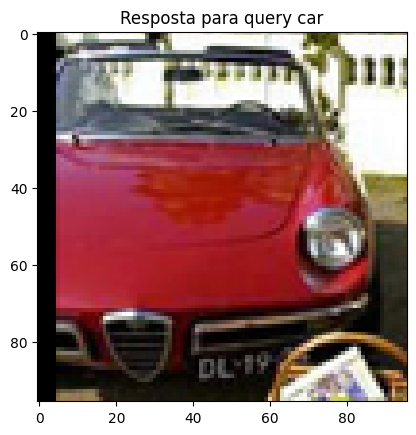

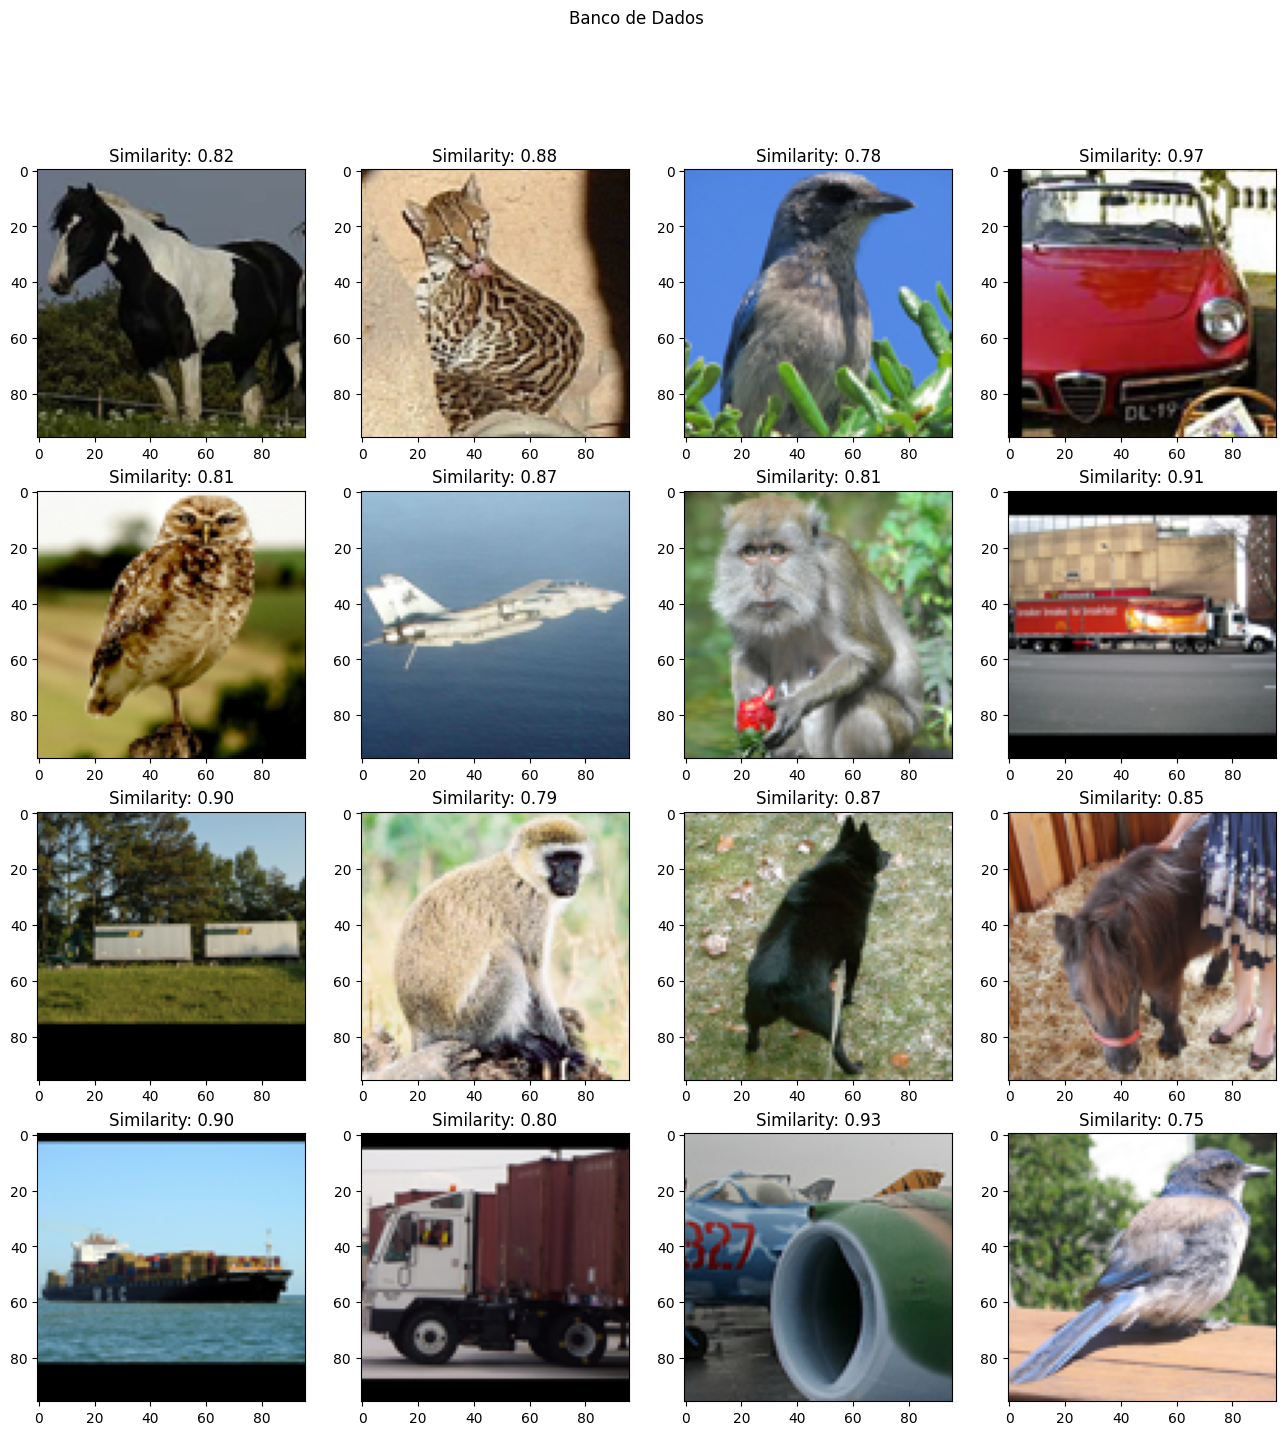

# Imports e bibliotecas

In [ ]:
!pip install torchinfo efficientnet-pytorch -q

  Preparing metadata (setup.py) ... done


In [ ]:
import os
import math
import pandas as pd
import torch
import random
import logging
import torchinfo
from torch import nn
import torch.nn.functional as F
from pprint import pprint
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import STL10
from transformers import BertModel, BertTokenizer
from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt
import numpy as np

# Dataset
Implementação do dataset de pares de imagens e textos

In [ ]:
class STLDataset(Dataset):
    '''
    Dataset pronto para treino com MSE Loss

    CUIDADO: Não está correto para contrastive loss!
    '''
    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]
    def __init__(self, mode: str, tokenizer, transform: object):
        self.dataset = STL10(root='./data', split='train' if mode == "train" else "test",  transform=transform, download=True)
        self.classes = ('airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck')

        # Get labels from dataset
        self.labels = [label for _, label in self.dataset]

        self.class_to_idx = self._build_class_index()

        self.tokenizer = tokenizer
        print(f"Initialized {mode} data.")

    def _build_class_index(self):
        # Create a dictionary to store indices for each class
        class_to_idx = {}
        for idx, label in enumerate(self.labels):
            if label not in class_to_idx:
                class_to_idx[label] = []
            class_to_idx[label].append(idx)
        return class_to_idx

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, i):
        image, label = self.dataset[i]
        text = self.classes[label]

        text_tokens = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True)["input_ids"][0]

        return {"image": image,
                "label": label,
                "text": text,
                "text_tokens": text_tokens}

text_model = "bert-base-uncased"
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=STLDataset.MEAN, std=STLDataset.STD)])
tokenizer = BertTokenizer.from_pretrained(text_model)
train_data = STLDataset("train", tokenizer, transform)
val_data = STLDataset("val", tokenizer, transform)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


100%|██████████| 2640397119/2640397119 [04:55<00:00, 8930112.23it/s]


Extracting ./data/stl10_binary.tar.gz to ./data
Initialized train data.
Files already downloaded and verified
Initialized val data.


## Debug do Dataset

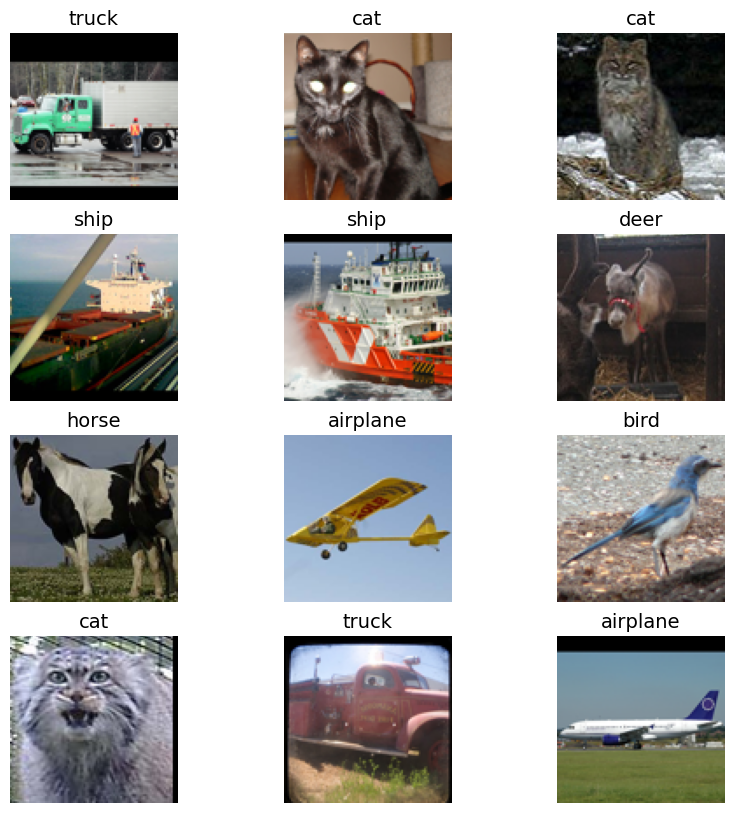

In [ ]:
#@title Plot samples

# Set seed for reproducibility
seed = 2
samples = 12

def denormalize(tensor, mean=STLDataset.MEAN, std=STLDataset.STD):
    """Denormalizes an image tensor."""
    # Create a tensor of the same size as the input tensor
    denormalized_tensor = torch.zeros_like(tensor)

    # Iterate over the channels (RGB)
    for i in range(3):
        denormalized_tensor[i] = tensor[i] * std[i] + mean[i]

    return denormalized_tensor

def plot_samples(train_data, samples, seed):
    # Calculate the maximum number of samples
    max_samples = len(train_data)

    # Choose random n samples between 0 and max_samples
    np.random.seed(seed)
    idx = np.random.randint(0, max_samples, samples)

    # Calculate grid dimensions
    num_rows = math.ceil(math.sqrt(samples))
    num_cols = samples // num_rows
    if samples % num_rows != 0:
        num_cols += 1

    # Create a figure and axes
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

    # Iterate over idx
    for i in range(samples):
        # Calculate row and column index
        row = i // num_cols
        col = i % num_cols

        # Inverse standar normalization and permute channel dimension
        image = denormalize(train_data[idx[i]]['image'])
        image = image.permute(1, 2, 0)
        # Plot the image on the corresponding axes
        axes[row, col].imshow(image)
        axes[row, col].axis('off')  # Hide axes

        axes[row, col].set_title(train_data[idx[i]]['text'])
        axes[row, col].title.set_fontsize(14) # title size

    # Show the plot
    plt.show()

plot_samples(train_data, samples, seed)

## DataLoader e Debug do DataLoader


In [ ]:
#@title Custom DataLoader

# TODO Implemente um debug do DataLoader, visualize e comente sobre o conteúdo do batch, explicando se está tudo correto
class ContrastiveBatchSampler:
    def __init__(self, dataset, batch_size):
        """
        Args:
            dataset (CustomContrastiveDataset): Custom dataset with data and labels
            batch_size (int): Number of samples per batch
        """
        self.dataset = dataset
        self.batch_size = batch_size
        self.class_to_idx = dataset.class_to_idx
        self.classes = list(self.class_to_idx.keys())
        self.num_batches = len(self.dataset) // self.batch_size  # Total number of batches per epoch

    def __iter__(self):
        # Generate batches ensuring no repeated classes in each batch
        for _ in range(self.num_batches):
            selected_classes = random.sample(self.classes, self.batch_size)
            indices = []
            for cls in selected_classes:
                idx = random.choice(self.class_to_idx[cls])
                indices.append(idx)
            yield indices

    def __len__(self):
        return self.num_batches


batch_size = 10

sampler_train = ContrastiveBatchSampler(train_data, batch_size=batch_size)
train_loader = DataLoader(train_data, batch_sampler=sampler_train)

sampler_val = ContrastiveBatchSampler(val_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_sampler=sampler_val)

sample = next(iter(train_loader))
print(f'Shape of image: {sample.get("image").shape}')
print(f'Shape of text : {sample.get("text_tokens").shape}')

Shape of image: torch.Size([10, 3, 96, 96])
Shape of text : torch.Size([10, 3])


In [ ]:
#@title Check for class repetition

# Iterate over the dataset and check for class repetition
for batch in train_loader:
    # Count unique labels
    unique_labels, counts = torch.unique(batch['label'], return_counts=True)

    # Check for class repetition
    if torch.any(counts > 1):
        print("Class repetition detected!")
        break
else:
    print("No class repetition found.")

No class repetition found.


# Arquitetura

Utilizamos modelos pré-treinados congelados e treinamos uma camada de projeção de um Embedding para o espaço do outro.

O design aqui é livre e você pode experimentar com modelos pré-treinados diferentes, mais de uma projeção linear, não congelar um dos modelos grandes (pesado), etc.

## Models definition

In [ ]:
class LinearProjection(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(LinearProjection, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [ ]:
class ImageModel(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()

        self.pretrained_image_model = kwargs.get("pretrained_image_model", "efficientnet-b0")
        self.freeze = kwargs.get("freeze", True)
        self.projection_size = kwargs.get("projection_size", 1024)

        # Gerador de Embeddings a partir de imagens
        self.image_model = EfficientNet.from_pretrained(self.pretrained_image_model)
        self.image_projection = LinearProjection(kwargs["emb_size"], kwargs["emb_size"], self.projection_size)

        if self.freeze:
            for param in self.image_model.parameters():
                param.requires_grad = False

        # Pesos de projeção dos embeddings não são congelados!
        # Dica: uma boa representação linear da imagem é a entrada da camda Fully Connected da EfficientNet que classifica imagens.
        # Neste exemplo, substituimos ela por nossa projeção para o tamanho de embedding do BERT (emb_size)
        self.image_model._fc = nn.Linear(self.image_model._fc.in_features, kwargs["emb_size"])

    def forward(self, x):
        x = self.image_model(x)
        return self.image_projection(x)


In [ ]:
class TextModel(nn.Module):
    # *args e **kwargs é uma representação genérica de argumentos, substitua pelo seu design.
    def __init__(self, **kwargs):
        super().__init__()
        self.pretrained_text_model = kwargs.get("pretrained_text_model", "bert-base-uncased")
        self.freeze = kwargs.get("freeze", True)
        self.projection_size = kwargs.get("projection_size", 1024)

        self.text_model = BertModel.from_pretrained(self.pretrained_text_model)
        self.text_projection = LinearProjection(self.text_model.config.hidden_size, kwargs['emb_size'], self.projection_size)

        if self.freeze:
            for param in self.text_model.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        x = self.text_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        x = x.pooler_output # get [cls] token
        return  self.text_projection(x)

## Implementação da arquitetura multimodal
Vamos unir instâncias das classes de interpretação de imagem e texto acima para retornar os dois embeddings pareados para treino.

In [ ]:
#@title Create model

class Multimodal(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        # TODO Inicializar o ImageModel, TextModel, ajuste parâmetros para sua preferência
        self.image_model = ImageModel(**kwargs)
        self.text_model = TextModel(**kwargs)

    def forward(self, batch_image, batch_text):
        # TODO computar embeddings de imagem projetados e alinhados com o de texto
        # DICA: inclua asserts para garantir que os dois embeddings tem a mesma dimensão
        image_embedding = self.image_model(batch_image)
        text_embedding = self.text_model(batch_text)
        assert image_embedding.shape == text_embedding.shape, "Image and text embeddings must have the same shape"
        return image_embedding, text_embedding

Hyperparameters = {
    "pretrained_image_model": "efficientnet-b0",
    "pretrained_text_model": "bert-base-uncased",
    "freeze": True,
    "emb_size": 768,
    "projection_size": 2048
}

model = Multimodal(**Hyperparameters)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 33.5MB/s]


Loaded pretrained weights for efficientnet-b0


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Visualize a arquitetura para checar se está correta

In [ ]:
#@title Visualização dos parâmetros
torchinfo.summary(model, depth=3, input_data=(sample["image"], sample["text_tokens"]))

Layer (type:depth-idx)                                            Output Shape              Param #
Multimodal                                                        [10, 768]                 --
├─ImageModel: 1-1                                                 [10, 768]                 --
│    └─EfficientNet: 2-1                                          [10, 768]                 --
│    │    └─Conv2dStaticSamePadding: 3-1                          [10, 32, 48, 48]          (864)
│    │    └─BatchNorm2d: 3-2                                      [10, 32, 48, 48]          (64)
│    │    └─MemoryEfficientSwish: 3-3                             [10, 32, 48, 48]          --
│    │    └─ModuleList: 3-4                                       --                        (3,594,460)
│    │    └─Conv2dStaticSamePadding: 3-5                          [10, 1280, 3, 3]          (409,600)
│    │    └─BatchNorm2d: 3-6                                      [10, 1280, 3, 3]          (2,560)
│    │    └─MemoryE

In [ ]:
#@title Check train parameters
print("Trainable parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.requires_grad}")

Trainable parameters:
image_model.image_model._fc.weight: True
image_model.image_model._fc.bias: True
image_model.image_projection.linear1.weight: True
image_model.image_projection.linear1.bias: True
image_model.image_projection.linear2.weight: True
image_model.image_projection.linear2.bias: True
text_model.text_projection.linear1.weight: True
text_model.text_projection.linear1.bias: True
text_model.text_projection.linear2.weight: True
text_model.text_projection.linear2.bias: True


# Treinamento com MSELoss
Implemente o treinamento, primeiro utilizando MSELoss

In [ ]:
#@title Train functions

import time

def plot_learning_curves(history):
  plt.figure(figsize=(7, 4))
  plt.plot(history['train_loss'], label='train')
  plt.plot(history['eval_loss'], label='eval')
  plt.legend()
  plt.title('Loss')
  plt.xlabel('epoch')
  plt.show()

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    test_acc = 0.0
    for batch in train_loader:
        img = batch["image"].to(device)
        txt = batch["text_tokens"].to(device)

        img_emb, txt_emb = model(img, txt)

        # Calculate loss
        loss = criterion(img_emb, txt_emb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

def valid_epoch(model, valid_loader, criterion, device):
    ## evaluation
    val_acc = 0
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for batch in valid_loader:
            img = batch["image"].to(device)
            txt = batch["text_tokens"].to(device)

            img_emb, txt_emb = model(img, txt)

            # Calculate loss
            loss = criterion(img_emb, txt_emb)
            val_loss += loss.item()

    return val_loss / len(valid_loader)

def train(model, train_loader, valid_loader, criterion, optimizer, epochs, device):
    # Save history to dictionnary
    history = {
        'train_loss': [],
        'eval_loss': [],
        'train_acc': [],
        'eval_acc': []
    }

    # Move the model to the appropriate device (GPU or CPU)
    model.to(device)

    # Initial evaluation
    ini_loss = valid_epoch(model, valid_loader, criterion, device)
    print(f'[Initial] Test loss:{ini_loss:.4f}')

    # Training loop
    for epoch in range(epochs):
        start_time_epoch = time.time()  # Start time of the epoch

        # train model
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)

        # evaluate model
        val_loss = valid_epoch(model, valid_loader, criterion, device)

        end_time = time.time()  # End time of the epoch
        epoch_duration = end_time - start_time_epoch  # Duration of epoch

        history['train_loss'].append(train_loss)
        history['eval_loss'].append(val_loss)

        perplexity = torch.exp(torch.tensor(val_loss))
        print(f'Epoch [{epoch+1}/{epochs}], Train loss:{train_loss:.4f}, '
              f'Test loss:{val_loss:.4f}, Elapsed Time: {epoch_duration:.2f} sec')

    return history

In [ ]:
#@title Run training

from torch.nn import MSELoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

epochs = 5
lr = 1e-4; """TODO, experimente!"""

# Model instantiation
model = Multimodal(**Hyperparameters)

criterion = MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

history = train(model, train_loader, val_loader, criterion, optimizer, epochs, device)

Using device: cuda
Loaded pretrained weights for efficientnet-b0
[Initial] Test loss:0.0195
Epoch [1/5], Train loss:0.0005, Test loss:0.0002, Elapsed Time: 44.42 sec
Epoch [2/5], Train loss:0.0000, Test loss:0.0003, Elapsed Time: 46.72 sec
Epoch [3/5], Train loss:0.0000, Test loss:0.0002, Elapsed Time: 45.42 sec
Epoch [4/5], Train loss:0.0000, Test loss:0.0001, Elapsed Time: 44.45 sec
Epoch [5/5], Train loss:0.0000, Test loss:0.0001, Elapsed Time: 45.02 sec


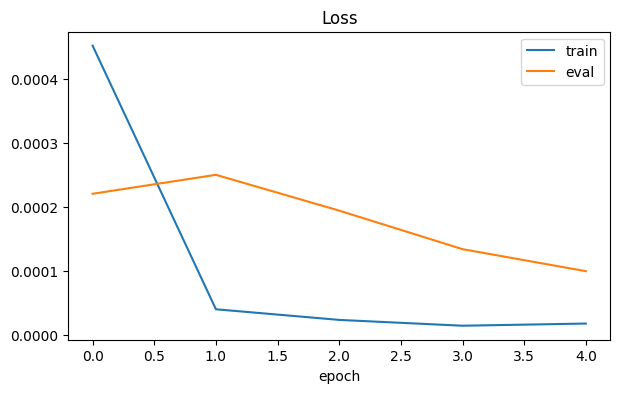

In [ ]:
#@title Plot learning curves

plot_learning_curves(history)

# Query
Com um batch de imagens e uma string única de query, retorne qual a imagem correspondente usando Cosine Similarity (exemplo de saída esperada no início do notebook)

Faça debugs e confirme que está funcionando corretamente..

In [ ]:
#@title Function definition


def cosine_similarity(a, b):
    """
    Calculates the cosine similarity between two tensors.

    Args:
      a: First tensor.
      b: Second tensor.

    Returns:
      The cosine similarity between a and b.
    """
    dot_product = torch.sum(a * b, dim=1)

    # Calculate norms for each row
    norm_a = torch.norm(a, dim=1)
    norm_b = torch.norm(b, dim=1)

    # Calculate cosine similarity for each row
    return dot_product / (norm_a * norm_b)

def query(multimodal_model: Multimodal,
          tokenizer,
          query: str,
          images: torch.Tensor,
          device):
    # Tokenizer query
    query_tokens = tokenizer(query, return_tensors="pt", padding=True, truncation=True)["input_ids"][0]
    # Expand query to batch size
    query_tokens = query_tokens.unsqueeze(0).expand(images.shape[0], -1)
    # get embeddings
    img_emb, txt_emb = multimodal_model(images.to(device), query_tokens.to(device))
    # get cosine similarity
    cos_sim = cosine_similarity(img_emb, txt_emb)

    # Argument sort
    sorted_indices = torch.argsort(cos_sim, descending=True)

    # Plot the first similarity
    fig, ax = plt.subplots( figsize=(3, 4))
    ax.imshow(denormalize(images[sorted_indices[0]]).permute(1, 2, 0))
    ax.set_title(f"Response to query: {query}\nSimilarity: {cos_sim[sorted_indices[0]]:.3f}")
    ax.axis('off')
    plt.show()
    print()

    # Plot images and cosine similarity
    max_samples = len(images)
    num_rows = round(math.sqrt(max_samples))
    num_cols = max_samples // num_rows
    if max_samples % num_rows != 0:
        num_cols += 1

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    for i in range(max_samples):
        # Calculate row and column index
        row = i // num_cols
        col = i % num_cols

        # Inverse standar normalization and permute channel dimension
        image = denormalize(images[sorted_indices[i]])
        image = image.permute(1, 2, 0)
        # Plot the image on the corresponding axes
        axes[row, col].imshow(image)
        axes[row, col].axis('off')  # Hide axes

        axes[row, col].set_title(f"Similarity: {cos_sim[sorted_indices[i]]:.3f}")
        axes[row, col].title.set_fontsize(14) # title size

    # title
    fig.suptitle(f"Sorted dataset", fontsize=16)
    # Adjust the padding between and around subplots.
    #plt.tight_layout(pad=0.5)
    # Show the plot
    plt.show()

def sample_images(dataset, num_samples, seed=2):
    max_data = len(train_data)
    random.seed(seed)
    # random samples
    random_indices = random.sample(range(max_data), num_samples)

    search_data = []
    for idx in random_indices:
        search_data.append(train_data[idx])

    return torch.stack([item["image"] for item in search_data])

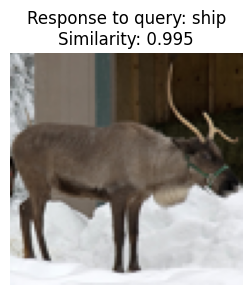

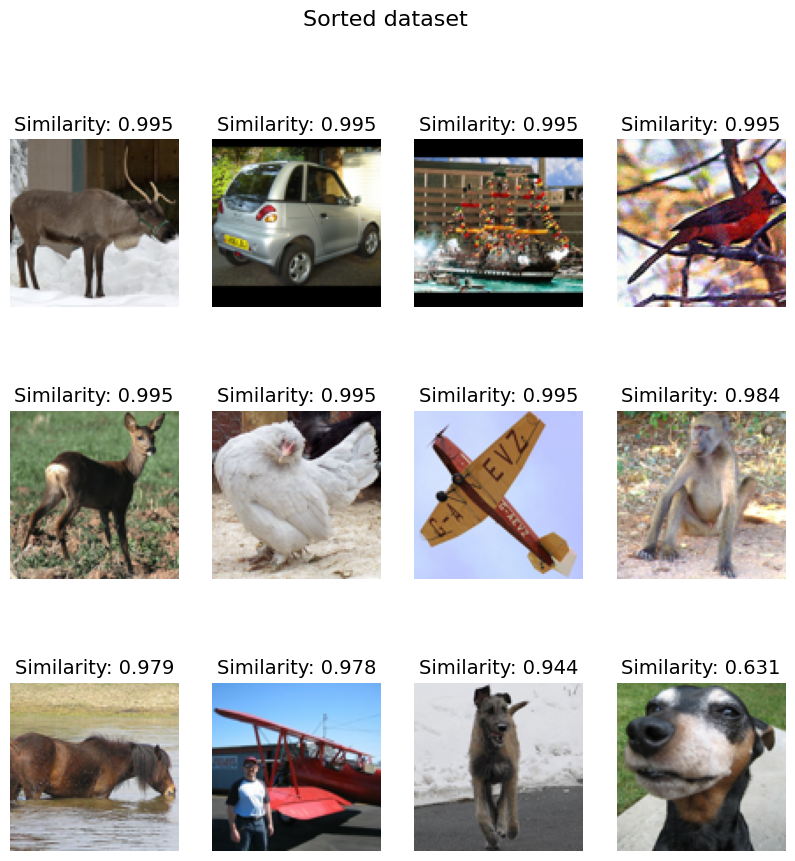

In [ ]:
#@title Search image

img_to_search = sample_images(val_data, num_samples=12, seed=2)

# run query
#('airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck')
query(model, tokenizer, "ship", img_to_search, device)

# Treinamento com  Contrastive Loss
Implemente contrastive loss inspirada pelo CLIP e treine novamente

In [ ]:
#@title Contrastive Loss

class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, image_features: torch.Tensor,
                text_features: torch.Tensor) -> torch.Tensor:
        """
        Args:
            image_features (torch.Tensor): Tensor of shape [batch_size, feature_dim] representing image embeddings.
            text_features (torch.Tensor): Tensor of shape [batch_size, feature_dim] representing text embeddings.

        Returns:
            torch.Tensor: Contrastive loss for CLIP.
        """
        # Normalize the image and text features
        image_features = F.normalize(image_features, dim=-1)
        text_features = F.normalize(text_features, dim=-1)

        # Calculate the cosine similarity between image and text embeddings
        logits_per_image = torch.matmul(image_features, text_features.t()) / self.temperature
        logits_per_text = logits_per_image.t()

        # Create the labels (matching image-text pairs have the same index)
        batch_size = image_features.shape[0]
        labels = torch.arange(batch_size, device=image_features.device)

        # Cross entropy loss for both directions (image -> text and text -> image)
        loss_i2t = F.cross_entropy(logits_per_image, labels)
        loss_t2i = F.cross_entropy(logits_per_text, labels)

        # Return the average loss
        return (loss_i2t + loss_t2i) / 2


In [ ]:
#@title Run training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

epochs = 5
lr = 1e-4; """TODO, experimente!"""

# Model instantiation
contrastive_model = Multimodal(**Hyperparameters)

criterion = ContrastiveLoss()
optimizer = torch.optim.AdamW(contrastive_model.parameters(), lr=lr)

history = train(contrastive_model, train_loader, val_loader, criterion, optimizer, epochs, device)

Using device: cuda
Loaded pretrained weights for efficientnet-b0
[Initial] Test loss:2.3349
Epoch [1/5], Train loss:1.6787, Test loss:0.9520, Elapsed Time: 44.70 sec
Epoch [2/5], Train loss:0.9570, Test loss:0.8963, Elapsed Time: 45.44 sec
Epoch [3/5], Train loss:0.7474, Test loss:0.8513, Elapsed Time: 46.27 sec
Epoch [4/5], Train loss:0.6755, Test loss:0.7398, Elapsed Time: 45.93 sec
Epoch [5/5], Train loss:0.6133, Test loss:0.7544, Elapsed Time: 45.19 sec


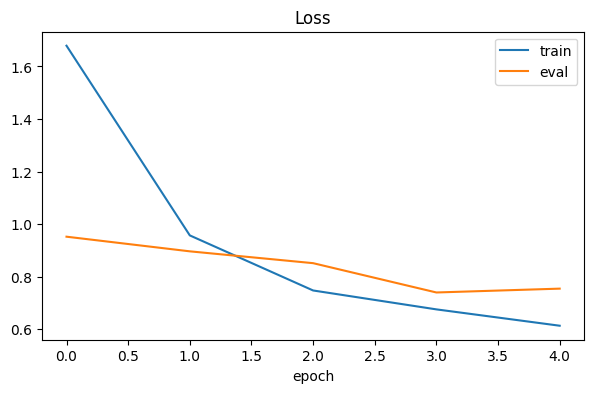

In [ ]:
#@title Plot learning curves

plot_learning_curves(history)

# Query com modelo treinado com Contrastive Loss

Espera-se que as Cosine Similarities sejam mais próximas de zero para pares negativos!

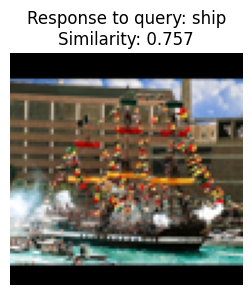

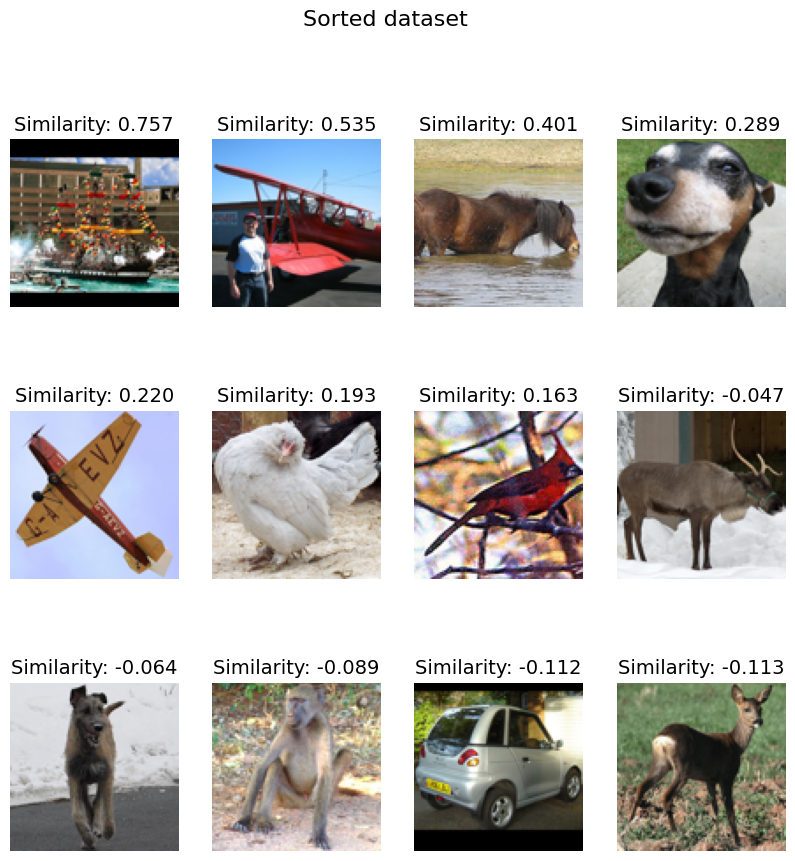

In [ ]:
#@title Search image

img_to_search = sample_images(val_data, num_samples=12, seed=2)

# run query
#('airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck')
query(contrastive_model, tokenizer, "ship", img_to_search, device)